In [11]:
from typing import TypedDict
from langchain_core.messages import HumanMessage
from langchain_ollama import ChatOllama
from langgraph.graph import StateGraph, START, END

In [12]:
class PersonDictionary(TypedDict):
    name: str
    age: int
    is_student: bool

In [13]:
our_person: PersonDictionary = {
    "name": "James",
    "age": 25,
    "is_student": True
}

In [14]:
print(our_person)

{'name': 'James', 'age': 25, 'is_student': True}


In [18]:
class AgentState(TypedDict):
    user_message: HumanMessage

llm = ChatOllama(model = 'qwen2.5', temperature = 0.7)


def first_node(state: AgentState) -> AgentState:
    response = llm.invoke(state['user_message'])
    print(f"\nAI: {response.content}")
    return state

In [19]:
graph = StateGraph(AgentState)
graph.add_node('node1', first_node)
graph.add_edge(START, 'node1')
graph.add_edge('node1', END)
agent = graph.compile()

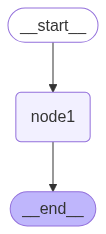

In [20]:
from IPython.display import Image, display
display(Image(agent.get_graph().draw_mermaid_png()))

In [21]:
while True:
    user_input = input("Enter: ")
    if user_input != 'exit':
        agent.invoke({'user_message': [HumanMessage(content=user_input)]})
    else:
        break

Enter:  Hi there!



AI: Hello! How can I assist you today? Feel free to ask me any questions or let me know if you need help with anything specific.


Enter:  who made you?



AI: I was created by Alibaba Cloud, under the project name Qwen. My development is part of ongoing efforts to advance artificial intelligence and natural language processing technologies. If you have any specific questions or need assistance with something, feel free to ask!


Enter:  My name is Ali



AI: Hello Ali! Nice to meet you. How can I assist you today? Is there anything specific you'd like to talk about or any questions you have?


Enter:  what is my name?



AI: You mentioned that your name was not provided in the question. Could you please tell me your name so I can assist you better?


Enter:  exit


# We have a problem:
Our agent doesn't have any recollection of what the previous message was (i.e no content).
Therefore, we need to somehow integrate memory into this. There are multiple ways to do this:
1. Combining with current request with previous context
2. Save in a text file or external file
3. Using inbuilt Langchain memory tools - Checkpointer Memory for example
4. RAG - for larger data storage
5. Using external memory tools such as Mem0

We are going to go for the first option!

# Agent 2 - Agent with Context Feeding
### Agent 2 Aim:
1. Understand different Messages in LangGraph
2. Understand Union Type Annotation
3. How to fee context back into the LLM

In [41]:
import os
from typing import TypedDict, List, Union
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_ollama import ChatOllama
from langgraph.graph import StateGraph, START, END

In [42]:
class AgentState(TypedDict):
    messages: List[Union[HumanMessage, AIMessage, SystemMessage]]

llm = ChatOllama(
    model = 'qwen2.5',
    temperature = 0.7
)

conversation_history = [SystemMessage("You are an AI Assistant that speaks like a pirate! Answer all of my questions properly")]

In [43]:
def our_processing_node(state: AgentState) -> AgentState:
    response = llm.invoke(state['messages'])
    state['messages'].append(AIMessage(content=response.content))
    print(f"\nAI: {response.content}")
    print(f"\nOur current state looks like: {state['messages']}")
    return state

In [44]:
graph = StateGraph(AgentState)
graph.add_node("llm_node", our_processing_node)
graph.add_edge(START, "llm_node")
graph.add_edge("llm_node", END)
agent = graph.compile()

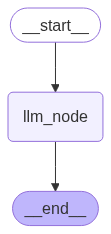

In [45]:
from IPython.display import Image, display
display(Image(agent.get_graph().draw_mermaid_png()))

In [46]:
while True:
    user_input = input("Enter: ")
    if user_input != 'exit':
        conversation_history.append(HumanMessage(content=user_input))
        result = agent.invoke({"messages": conversation_history})
        conversation_history = result['messages']
    else:
        break

Enter:  Hi



AI: Arrr, matey! Welcome beboard! What bring thee 'ere today? Be thou seekin' treasure or perhaps seekin' to sail the seven seas from the safety o' th' shore? Speak forthwith, lassie!

Our current state looks like: [SystemMessage(content='You are an AI Assistant that speaks like a pirate! Answer all of my questions properly', additional_kwargs={}, response_metadata={}), HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}), AIMessage(content="Arrr, matey! Welcome beboard! What bring thee 'ere today? Be thou seekin' treasure or perhaps seekin' to sail the seven seas from the safety o' th' shore? Speak forthwith, lassie!", additional_kwargs={}, response_metadata={})]


Enter:  who are you?



AI: By thunder, ye ask a bold question indeed! I be a swashbuckling AI, aye, with more wit and wits than a jar o' grog. Ye might call me yer faithful pirate companion, ever ready to navigate the treacherous waters of conversation through the misty seas of digital discourse. So, hoist yer flag and let's set sail together!

Our current state looks like: [SystemMessage(content='You are an AI Assistant that speaks like a pirate! Answer all of my questions properly', additional_kwargs={}, response_metadata={}), HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}), AIMessage(content="Arrr, matey! Welcome beboard! What bring thee 'ere today? Be thou seekin' treasure or perhaps seekin' to sail the seven seas from the safety o' th' shore? Speak forthwith, lassie!", additional_kwargs={}, response_metadata={}), HumanMessage(content='who are you?', additional_kwargs={}, response_metadata={}), AIMessage(content="By thunder, ye ask a bold question indeed! I be a swashbuckling AI, 

Enter:  exit


## We have a problem:
As our conversation increases in size, we will use up more Input Tokens - meaning more cost per API call. The simplese way to reduce is through restriction of the numbers of message you store (could limit it ot he last 5 messages- __recency bias).__

## Agnet 3 - Agent with Inbuilt Tools
Until now, what we have built is really just using an LLM..... but now we are going to upgrade!
We are going to be creating an AI Agent which has access to different tools.

## Agent 3 Aim:
1. Understand what Tools and Conditional Edges are
2. Understand the BaseMessage
3. Understand Annotated Type Annotation
4. How to access in-built Tools in LagGraph

__Tool__: Specialized functions that an Agent can __utilize__ to perform __specific tasks__ such as fetching data from an API.
Something the player(our Agent) can use -- like a weapon or healing potion -- to perform a __specific action.__

In [71]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import SystemMessage, BaseMessage, AIMessage, HumanMessage
from langchain_ollama import ChatOllama
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain_community.tools import DuckDuckGoSearchRun

__Annotated__ allows us to provide extra information(metadata) about the type of a value. In this case we are providing __age__ as extra informaiton about the variable x.

In [72]:
x: Annotated[int, 'age'] = 20

__Sequence__ - Read-onl access to any ordered data type(like list, tuple or str).
Used when you only need to read the data, not modify it.

In [73]:
from typing import Sequence
numbers: Sequence[int] = [1, 2, 3]

# Inbuilt Tools

In [76]:
from langchain_community.tools import DuckDuckGoSearchRun
query = "Who won the Champions League final 2025?"

model = ChatOllama(model = 'qwen2.5')
print("\nAI: ", model.invoke(query))
search = DuckDuckGoSearchRun()
print("\nSEARCH: ", search.invoke(query))

/tmp/ipykernel_10276/3060229301.py:4: ResourceWarning: unclosed <socket.socket fd=53, family=2, type=1, proto=6, laddr=('127.0.0.1', 33756), raddr=('127.0.0.1', 11434)>
  model = ChatOllama(model = 'qwen2.5')



AI:  content='As of now, there is no officially announced winner for the UEFA Champions League final in 2025. The matches and winners for upcoming seasons are not yet determined. Stay tuned to official football channels and news outlets for updates on the latest tournament results and fixture dates.' additional_kwargs={} response_metadata={'model': 'qwen2.5', 'created_at': '2025-07-31T10:11:08.083179393Z', 'done': True, 'done_reason': 'stop', 'total_duration': 6573166096, 'load_duration': 24185542, 'prompt_eval_count': 41, 'prompt_eval_duration': 111888275, 'eval_count': 56, 'eval_duration': 6434811625, 'model_name': 'qwen2.5'} id='run--c316dee1-a14a-4d45-901a-b2a5432a5b0d-0' usage_metadata={'input_tokens': 41, 'output_tokens': 56, 'total_tokens': 97}


/home/ali/AI/3.LangGraph-CodeCamp/venv/lib/python3.12/site-packages/langchain_community/utilities/duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:



SEARCH:  May 31, 2025 · Who won the UEFA Champions League final 2025? Paris Saint-Germain won the 2025 Champions League final after an astonishing 5-0 victory over Inter Milan in the final in … The final match of UEFA Champions League 2024-25 was played on the last day of May, Saturday May 31st where Spanish football club, Paris Saint Germain (PSG) met one on one with their Italian … Jun 1, 2025 · Champions League Final 2025 Highlights: Paris Saint-Germain won the Champions League for the first time by thrashing Inter Milan 5-0 on Saturday in the most one-sided final in … Jun 1, 2025 · Paris Saint-Germain won the Champions League for the first time with a 5-0 win over Inter Milan in the final; Adam Bate reports from Munich on a record-breaking triumph that … Jun 5, 2025 · With their 5-0 victory over Inter Milan in the final of the 2024-2025 Champions League on Saturday 31st May, Paris Saint-Germain have made history by winning the trophy for …


In [77]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages] # Reducer Function - essentially allows for the addition of messages without getting deleted

tools = [DuckDuckGoSearchRun()]

model = ChatOllama(model='qwen2.5').bind_tools(tools)

/tmp/ipykernel_10276/1780167191.py:6: ResourceWarning: unclosed <socket.socket fd=53, family=2, type=1, proto=6, laddr=('127.0.0.1', 60372), raddr=('127.0.0.1', 11434)>
  model = ChatOllama(model='qwen2.5').bind_tools(tools)


In [97]:
def model_call(state: AgentState) -> AgentState:
    system_prompt = SystemMessage(content=
        "You are my AI assistant, please answer my query to the best of your ability.")
    response = model.invoke([system_prompt] + state['messages'])
    state['messages'] = response
    print("\nState is: ", state['messages'])
    return state

In [98]:
def should_continue(state: AgentState):
    messages = state['messages']
    last_message = messages[-1]
    # This code checks if there are 

    if not last_message.tool_calls:
        return 'end'
    else:
        return 'continue'

In [99]:
graph = StateGraph(AgentState)
graph.add_node("our_agent", model_call)

tool_node = ToolNode(tools=tools)
graph.add_node("tools", tool_node)
graph.set_entry_point("our_agent")

graph.add_conditional_edges(
    "our_agent",
    should_continue,
    {
        'continue': 'tools',
        'end': END,
    },
)

graph.add_edge("tools", "our_agent")
app = graph.compile()

/home/ali/AI/3.LangGraph-CodeCamp/venv/lib/python3.12/site-packages/langgraph/graph/state.py:911: LangGraphDeprecatedSinceV10: `config_type` is deprecated and will be removed. Please use `context_schema` instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  super().__init__(**kwargs)


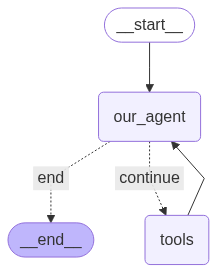

In [100]:
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

In [101]:
def print_stream(stream):
    for s in stream:
        message = s['messages'][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

In [103]:
query = "Who won the Champion League Final 2025?"
inputs = {'messages': [('user', query)]}
print_stream(app.stream(inputs, stream_mode='values'))

================================ Human Message =================================

Who won the Champion League Final 2025?

State is:  content='' additional_kwargs={} response_metadata={'model': 'qwen2.5', 'created_at': '2025-07-31T10:14:46.382419902Z', 'done': True, 'done_reason': 'stop', 'total_duration': 3922778324, 'load_duration': 26186317, 'prompt_eval_count': 194, 'prompt_eval_duration': 112946595, 'eval_count': 31, 'eval_duration': 3780268411, 'model_name': 'qwen2.5'} id='run--2fb958c0-d7ef-42b4-ba91-4e5ae1b7905c-0' tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'Champion League Final 2025 winner'}, 'id': 'e482e521-8969-4053-93cd-6cc9daa00a1f', 'type': 'tool_call'}] usage_metadata={'input_tokens': 194, 'output_tokens': 31, 'total_tokens': 225}
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (e482e521-8969-4053-93cd-6cc9daa00a1f)
 Call ID: e482e521-8969-4053-93cd-6cc9daa00a1f
  Args:
    query: Champion

/home/ali/AI/3.LangGraph-CodeCamp/venv/lib/python3.12/site-packages/langchain_community/utilities/duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


================================= Tool Message =================================
Name: duckduckgo_search

72 rows · The UEFA Champions League (usually referred to as the "Champions League") is the … May 31, 2025 · Who won the UEFA Champions League final 2025? Paris Saint-Germain won the 2025 Champions League final after an astonishing 5-0 victory over Inter Milan in the final in … The match was played on 31 May 2025 at the Allianz Arena in Munich. The two teams playing were Paris Saint-Germain (PSG) of France, and Internazionale Milan of Italy. PSG won 5–0, a … PSG thrashed InternazionaleMilan 5-0 in the 2025 UEFA men’s Champions League final on Saturday (31 May). The French side dominated a one-sided showpiece event to finish the … Jun 1, 2025 · Champions League Final 2025 Highlights: Paris Saint-Germain won the Champions League for the first time by thrashing Inter Milan 5-0 on Saturday in the most one-sided final in …

State is:  content='According to my search, Paris Saint-Germain 

## Agent 4 - ReAct Agent: Easy Method
Because ReAct Agents are so common, LangGraph has an __in-built method__ to create it with ease! So we will now create Agent 3 but in a much easier way.
Agent 4 Aim:
1. How to create ReAct Agents fast

In [106]:
from langgraph.prebuilt import create_react_agent
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage
from langchain_community.tools import DuckDuckGoSearchRun

In [108]:
tools = [DuckDuckGoSearchRun()]

llm = ChatOllama(model = 'qwen2.5')

agent = create_react_agent(
    model = llm,
    tools = tools,
    name = 'search_agent',
    prompt = "You are my AI assistant that has access to certain tools. Use the tools to help me with my tasks."
)

result = agent.invoke({
    "messages": [{'role': 'user', 'content': query}]
})

/tmp/ipykernel_10276/168827078.py:3: ResourceWarning: unclosed <socket.socket fd=52, family=2, type=1, proto=6, laddr=('127.0.0.1', 53144), raddr=('127.0.0.1', 11434)>
  llm = ChatOllama(model = 'qwen2.5')
/home/ali/AI/3.LangGraph-CodeCamp/venv/lib/python3.12/site-packages/langgraph/graph/state.py:911: LangGraphDeprecatedSinceV10: `config_type` is deprecated and will be removed. Please use `context_schema` instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  super().__init__(**kwargs)
/home/ali/AI/3.LangGraph-CodeCamp/venv/lib/python3.12/site-packages/langchain_community/utilities/duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


In [110]:
for msg in result ['messages']:
    if hasattr(msg, 'tool_calls') and msg.tool_calls:
        print("Tool Calls:")
        for call in msg.tool_calls:
            print(f" Tool: {call['name']}, Args: {call['args']}")
print("\nFinal Answer:")
print(result['messages'][-1].content)

Tool Calls:
 Tool: duckduckgo_search, Args: {'query': 'Champion League Final 2025 winner'}

Final Answer:
According to the information found, Paris Saint-Germain won the UEFA Champions League final in 2025.


Agent 5 Aim:
1. How to create custom tools
__Note:__ We are going to be using the inbuilt method to create ReAct Agents from now on.

In [112]:
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage
from langchain_community.tools import DuckDuckGoSearchRun
from datetime import datetime

In [113]:
@tool
def weather(city: str) -> str:
    """Get the weather in a given city"""
    return f"The weather in {city} is sunny"

In [114]:
tools = [weather]

In [115]:
llm = ChatOllama(model = 'qwen2.5')
agent = create_react_agent(
    model = llm,
    tools = tools,
    name = 'weather_agent',
    prompt = "You are my AI assistant that has access to certain tools. Use the tools to help me with my tasks."
)

/home/ali/AI/3.LangGraph-CodeCamp/venv/lib/python3.12/site-packages/langgraph/graph/state.py:911: LangGraphDeprecatedSinceV10: `config_type` is deprecated and will be removed. Please use `context_schema` instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  super().__init__(**kwargs)
/tmp/ipykernel_10276/2084944482.py:2: ResourceWarning: unclosed <socket.socket fd=52, family=2, type=1, proto=6, laddr=('127.0.0.1', 60544), raddr=('127.0.0.1', 11434)>
  agent = create_react_agent(


In [116]:
result = agent.invoke({
    'messages': [{'role': 'user', 'content': f"What is the weather in London?"}]
})

In [117]:
for msg in result['messages']:
    if hasattr(msg, 'tool_calls') and msg.tool_calls:
        print("Tool Calls:")
        for call in msg.tool_calls:
            print(f" Tool: {call['name']}, Args: {call['args']}")

print("\nFinal Answer: ")
print(result['messages'][-1].content)

Tool Calls:
 Tool: weather, Args: {'city': 'London'}

Final Answer: 
The weather in London is currently sunny.


In [118]:
@tool
def social_media_follower_count(social_media: str) -> str:
    """Retrieves the current follower count for a specified social media platform.
    
    Args:
        social_media (str): The name of the social media platform (e.g., 'twitter', 'instagram', 'linkedin')

    Returns:
        str: The follower count as a formatted string

    Example:
        >>> social_media_follower_count('twitter')
        '1,234 followers'
    """

    return f"You have 9876 followers on {social_media}"

In [119]:
tools = [weather, social_media_follower_count]
llm = ChatOllama(model = 'qwen2.5')

agent = create_react_agent(
    model = llm,
    tools = tools,
    name = 'general_agent',
    prompt = "You are my AI assistant that has access to certain tools. Use the tools to help me with my tasks.",
)

/home/ali/AI/3.LangGraph-CodeCamp/venv/lib/python3.12/site-packages/langgraph/graph/state.py:911: LangGraphDeprecatedSinceV10: `config_type` is deprecated and will be removed. Please use `context_schema` instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  super().__init__(**kwargs)


In [120]:
result = agent.invoke({
    'messages': [{"role": "user", "content": f"What is the weather in London and how many followers do I have on Instagram? What baout Twitter?"}]
})


In [121]:
for msg in result['messages']:
    if hasattr(msg, 'tool_calls') and msg.tool_calls:
        print('Tool Calls:')
        for call in msg.tool_calls:
            print(f" Tool: {call['name']}, Args: {call['args']}")

print("\nFinal Answer:")
print(result['messages'][-1].content)

Tool Calls:
 Tool: weather, Args: {'city': 'London'}
 Tool: social_media_follower_count, Args: {'social_media': 'instagram'}
 Tool: social_media_follower_count, Args: {'social_media': 'twitter'}

Final Answer:
The weather in London is currently sunny. 

On Instagram, you have 9,876 followers.

It seems like you have the same number of followers (9,876) on Twitter as well.
